#### we will start by downloading the dataset creating the model and finding out the predictions using this model. we can optimize different hyperparameter in order to tune this model for higher accuracy. this model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.

## 1. Loading The Data From **Kaggel**

In [1]:
# fistly download the API key from kaggle, then upload that api key by runing this cell
# Run this cell and select the kaggle.json file downloaded
# from the kaggle account settings page
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashdhakade","key":"6dbcf8a2c31462eb2a34a80c1fe016f1"}'}

We will start by connecting to kaggle API which can be downloaded from your Kaggle account's setting and upload it here (Upload box)

### Next we will install Kaggle API using pip installation

In [2]:
## Next, Install the Kaggle API client
!pip install -q kaggle

Setting up kaggle using kaggle API

In [3]:
# The Kaggle API client expects this file to be in -/.kaggle, so move it there
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

# This permissions chage avoids a warning on kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

To store the data we will create a new directory and make it as current working directory

In [4]:
# creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


Searching for the required dataset using search option(-s) with title 'dogbreedidfromcomp' we can also use different search options like search compititions, ntebooks, kernels, dataset,etc.

In [5]:
# Search for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           3739          8  0.1764706        


After searching the data next step would be downloading the data into collab notebook using references found in search option


In [6]:
# Downloading dataset and comming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 691M/691M [00:38<00:00, 23.3MB/s]
100% 691M/691M [00:38<00:00, 18.7MB/s]
/content


we will unzip the data which is downloaded and remove the irrelevant files.

In [7]:
# Unzipping downaded file and removing unusable file
!unzip /content/dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm /content/dog_dataset/dogbreedidfromcomp.zip
!rm /content/dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

Importing libraries.

In [8]:
# !pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Important library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

## 2. Load Labels  CSV For labels that contains images id and breed

In [10]:
# Reading  the label.csv and checking shape and records

all_labels = pd.read_csv("dog_dataset/labels.csv")
print(all_labels.shape)
all_labels.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## 3. Checking The breed Count

In [11]:
breed_count = all_labels["breed"].value_counts()
breed_count

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

we will work on only 3 breeds due to limited power. we can consider more classes as per the computational power

In [12]:
# Selecting first 3 breeds (Limitations due to computation power)

BREED_CLASS = ["scottish_deerhound", "maltese_dog", "bernese_mountain_dog"]
labels = all_labels[all_labels['breed'].isin(BREED_CLASS)]
labels.reset_index(inplace=True,drop=True)
labels.head()

,id,breed
0,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


## 4. One-Hot Encoding on Labels Data Prediction column

As we are working with the classification dataset first we need to one hot encode the target value i.e the classes. After that we will read images and convert them into numpy array and finaly normalizing the array

## 5. Load the images and convert them into array

## 6. Checked the shape and size of the X and Y data

In [13]:
# Creating numpy matrix with zero
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

# One Hot Encoding
Y_data = label_binarize(labels['breed'], classes = BREED_CLASS)


# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224,224))
  img = image.img_to_array(img)
  # print(img.shape)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x / 255.0


# Printing train image and one hot encode shape and size
print('\n Train image shape', X_data.shape,'size: {:,}'.format(X_data.size))
print('\n One-Hot encoded output shape', Y_data.shape,'size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:02<00:00, 138.34it/s]


 Train image shape (357, 224, 224, 3) size: 53,738,496

 One-Hot encoded output shape (357, 3) size: 1,071


## 7. Building the model network Architechture

In [14]:
# Building the model

IMAGE_SIZE  = 224
CHANNELS = 3

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(7,7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size=(5,5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(BREED_CLASS), activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"]) # here we don't have many classes, therefore we didnt use sparsecategorical_crossentropy

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

## 8 Split the data Fit it into The model And create An Accuracy plot

After defining the network architechture we will start with spliting the test and train data then dividing train data validation data

In [15]:
# splitting the data set into train and testing data set
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)

# splitting the training data set into training and validation data set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size=0.2)

Training a model

In [16]:
# model training
EPOCHS = 100
BATCH_SIZE=128

history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 17s 3s/step - loss: 4.8993 - accuracy: 0.4219 - val_loss: 4.8844 - val_accuracy: 0.3385
Epoch 2/100
2/2 [==============================] - 1s 424ms/step - loss: 4.8733 - accuracy: 0.4453 - val_loss: 4.8609 - val_accuracy: 0.3692
Epoch 3/100
2/2 [==============================] - 1s 444ms/step - loss: 4.8473 - accuracy: 0.4492 - val_loss: 4.8367 - val_accuracy: 0.3538
Epoch 4/100
2/2 [==============================] - 1s 400ms/step - loss: 4.8213 - accuracy: 0.4375 - val_loss: 4.8119 - val_accuracy: 0.3692
Epoch 5/100
2/2 [==============================] - 1s 521ms/step - loss: 4.7959 - accuracy: 0.4258 - val_loss: 4.7878 - val_accuracy: 0.3385
Epoch 6/100
2/2 [==============================] - 1s 459ms/step - loss: 4.7698 - accuracy: 0.4102 - val_loss: 4.7643 - val_accuracy: 0.3385
Epoch 7/100
2/2 [==============================] - 1s 483ms/step - loss: 4.7442 - accuracy: 0.3984 - val_loss: 4.7418 - val_accuracy: 0.3538
Epoch 8/100
2/2

## 9. Evaluate the model For Accuracy Score

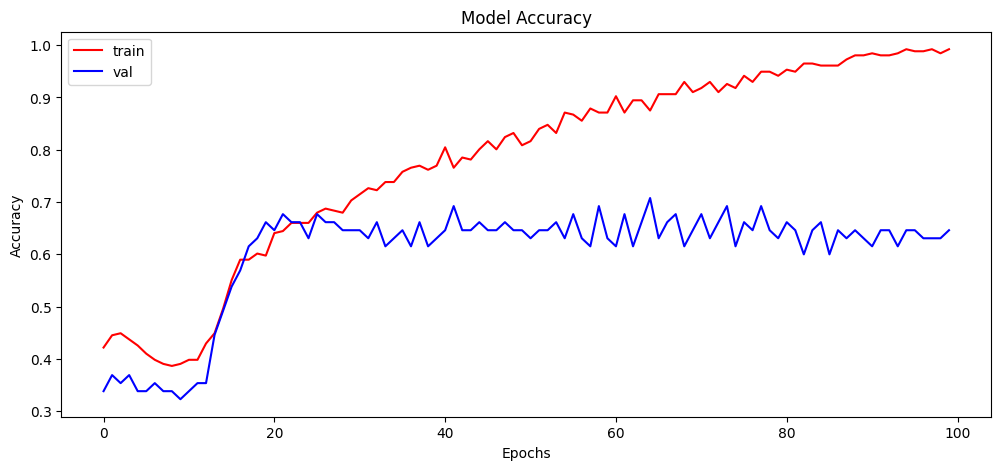

In [17]:
# plot the training history
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", 'val'])

plt.show()

## 10. Using the model for prediction

In [18]:
Y_pred  = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
# print(score) # [3.1358814239501953, 0.7777777910232544]
print('Accuracy over the rest set: \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 12ms/step - loss: 4.0969 - accuracy: 0.6389
Accuracy over the rest set: 
 63.89 %


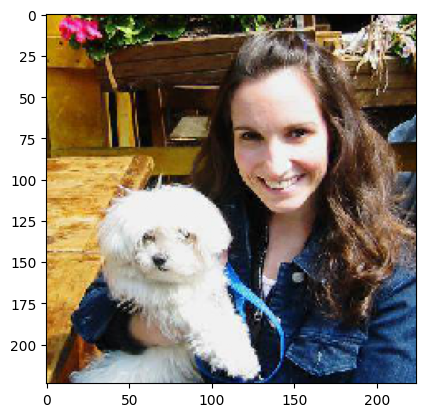

In [19]:
# Ploting images to compare
plt.imshow(X_test[3,:,:,:])
plt.show()

# Finding max value from prediction list and comparing originl value as predicted
print("originally : ", labels['breed'][np.argmax(Y_test[3])])
print("predicted : ", labels['breed'][np.argmax(Y_pred[3])])

originally :  maltese_dog
predicted :  scottish_deerhound


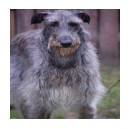

originally :  scottish_deerhound
predicted :  scottish_deerhound


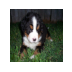

originally :  scottish_deerhound
predicted :  maltese_dog


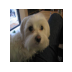

originally :  maltese_dog
predicted :  scottish_deerhound


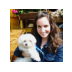

originally :  maltese_dog
predicted :  scottish_deerhound


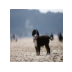

originally :  scottish_deerhound
predicted :  scottish_deerhound


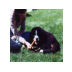

originally :  scottish_deerhound
predicted :  scottish_deerhound


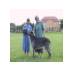

originally :  scottish_deerhound
predicted :  scottish_deerhound


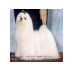

originally :  maltese_dog
predicted :  maltese_dog


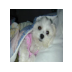

originally :  maltese_dog
predicted :  maltese_dog


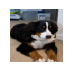

originally :  scottish_deerhound
predicted :  scottish_deerhound


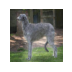

originally :  scottish_deerhound
predicted :  scottish_deerhound


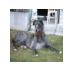

originally :  scottish_deerhound
predicted :  scottish_deerhound


In [20]:
plt.figure(figsize=(10,10))
for i in range(12):
  plt.subplot(6,2,i+1)
# Ploting images to compare
  plt.imshow(X_test[i])
  plt.axis("off")
  plt.show()

  # Finding max value from prediction list and comparing originl value as predicted
  print("originally : ", labels['breed'][np.argmax(Y_test[i])])
  print("predicted : ", labels['breed'][np.argmax(Y_pred[i])])

In [31]:
model.save("breed_prediction.h5")